In [33]:
import glob
import tifffile
import numpy as np
import lightgbm as lgb
import warnings
import tqdm

warnings.simplefilter('ignore')

In [66]:
train_path =  '/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/s2_image/'
mask_path = '/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/train/mask/'

masks = glob.glob(f'{mask_path}/*')
trains = glob.glob(f'{train_path}/*')
masks.sort()
trains.sort()

In [67]:
print("IMAGES Total:  {}".format(len(trains)))


IMAGES Total:  2066


In [68]:
X = []
y = []
g = []

for i, (t, m) in enumerate(zip(trains, masks)):
    img = tifffile.imread(t).astype(np.float64)
    # img = np.delete(img,[6,7,8],2)
    
    mask = tifffile.imread(m).astype(np.float64)
    # nb_one = len(mask[mask==1])
    # if nb_one==0:
    #     continue
    
    X.append(img.reshape(-1,12))
    # X.append(img.reshape(-1,9))
    y.append(mask.reshape(-1))
    g.append(np.ones_like(mask.reshape(-1))*i)
    
X = np.vstack(X)
y = np.hstack(y)
g = np.hstack(g) 

In [69]:
X.shape

(1133572, 12)

In [70]:
from sklearn.metrics import f1_score
lgb_params = {    
    'boosting_type':'gbdt',
    'learning_rate' : 0.1,
    'num_leaves':31,
    'max_depth':-1,
    'random_state':136,
	'n_estimators':2000,
	'objective':'binary'
    }

def evaluate_macroF1_lgb(y_true, y_pred):  

    y_pred_label = np.round(y_pred)

    f1 = f1_score(y_true, y_pred_label, average='binary')

    print('f1 score:', f1)

    return ('f1_score', f1, True)

In [71]:
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

#gkfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=136)
gkfold = GroupKFold(n_splits=4)

models = []

for i, (train_idx, valid_idx) in enumerate(gkfold.split(X, y, g)):
    train_x = X[train_idx]
    train_y = y[train_idx]
    
    val_x = X[valid_idx]
    val_y = y[valid_idx]
    
    m = lgb.LGBMClassifier(**lgb_params)
    m.fit(train_x, train_y, 
         # eval_metric='f1',
         eval_metric= evaluate_macroF1_lgb,
         eval_set=[(val_x, val_y)],
         callbacks=[lgb.log_evaluation(100)])
    
    models.append(m)

[LightGBM] [Info] Number of positive: 81882, number of negative: 768528
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 850410, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.096285 -> initscore=-2.239198
[LightGBM] [Info] Start training from score -2.239198
f1 score: 0.0
f1 score: 0.0
f1 score: 0.0
f1 score: 0.0
f1 score: 0.0
f1 score: 0.25713571249955347
f1 score: 0.43222635326737663
f1 score: 0.567957607531428
f1 score: 0.6210534729438094
f1 score: 0.6578093461764482
f1 score: 0.6835392980721701
f1 score: 0.690902892763222
f1 score: 0.6994259913058096
f1 score: 0.7057399230878793
f1 score: 0.7108935589391195
f1 score: 0.7172098661817504
f1 score: 0.7231518452696932
f1 score: 0.7299714122

In [72]:
models

[LGBMClassifier(n_estimators=2000, objective='binary', random_state=136),
 LGBMClassifier(n_estimators=2000, objective='binary', random_state=136),
 LGBMClassifier(n_estimators=2000, objective='binary', random_state=136),
 LGBMClassifier(n_estimators=2000, objective='binary', random_state=136)]

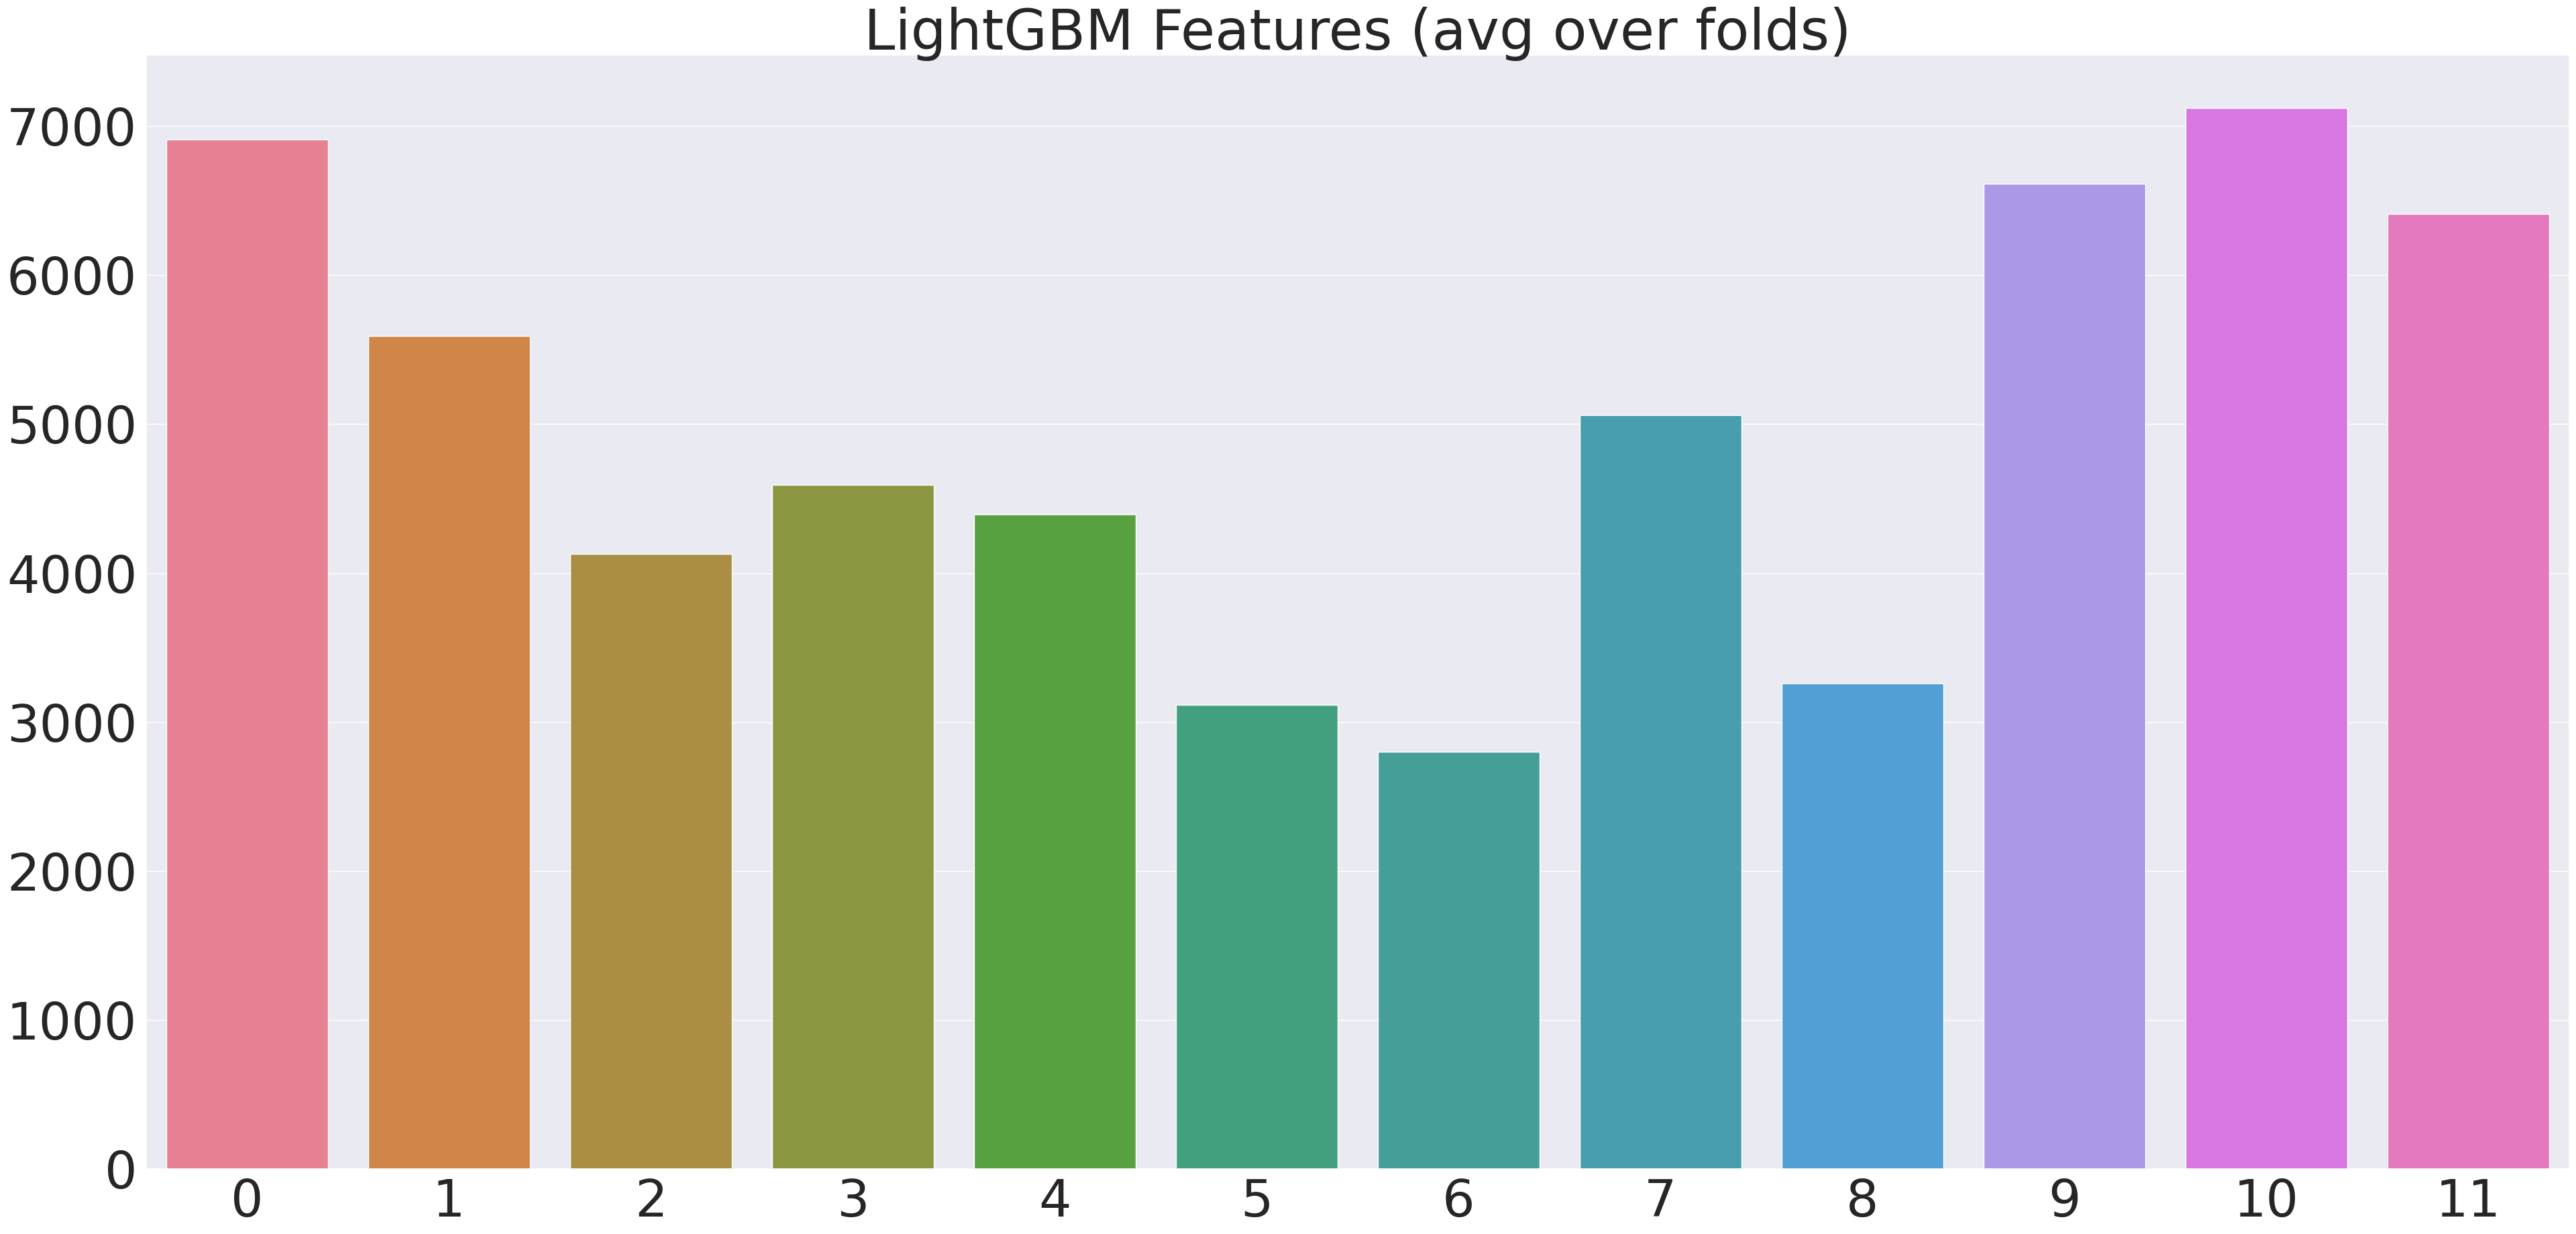

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

df_feature_importance = pd.DataFrame({'Value':models[0].feature_importances_})
df_feature_importance = df_feature_importance.T
plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)
sns.barplot(df_feature_importance)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances-01.png')
plt.show()

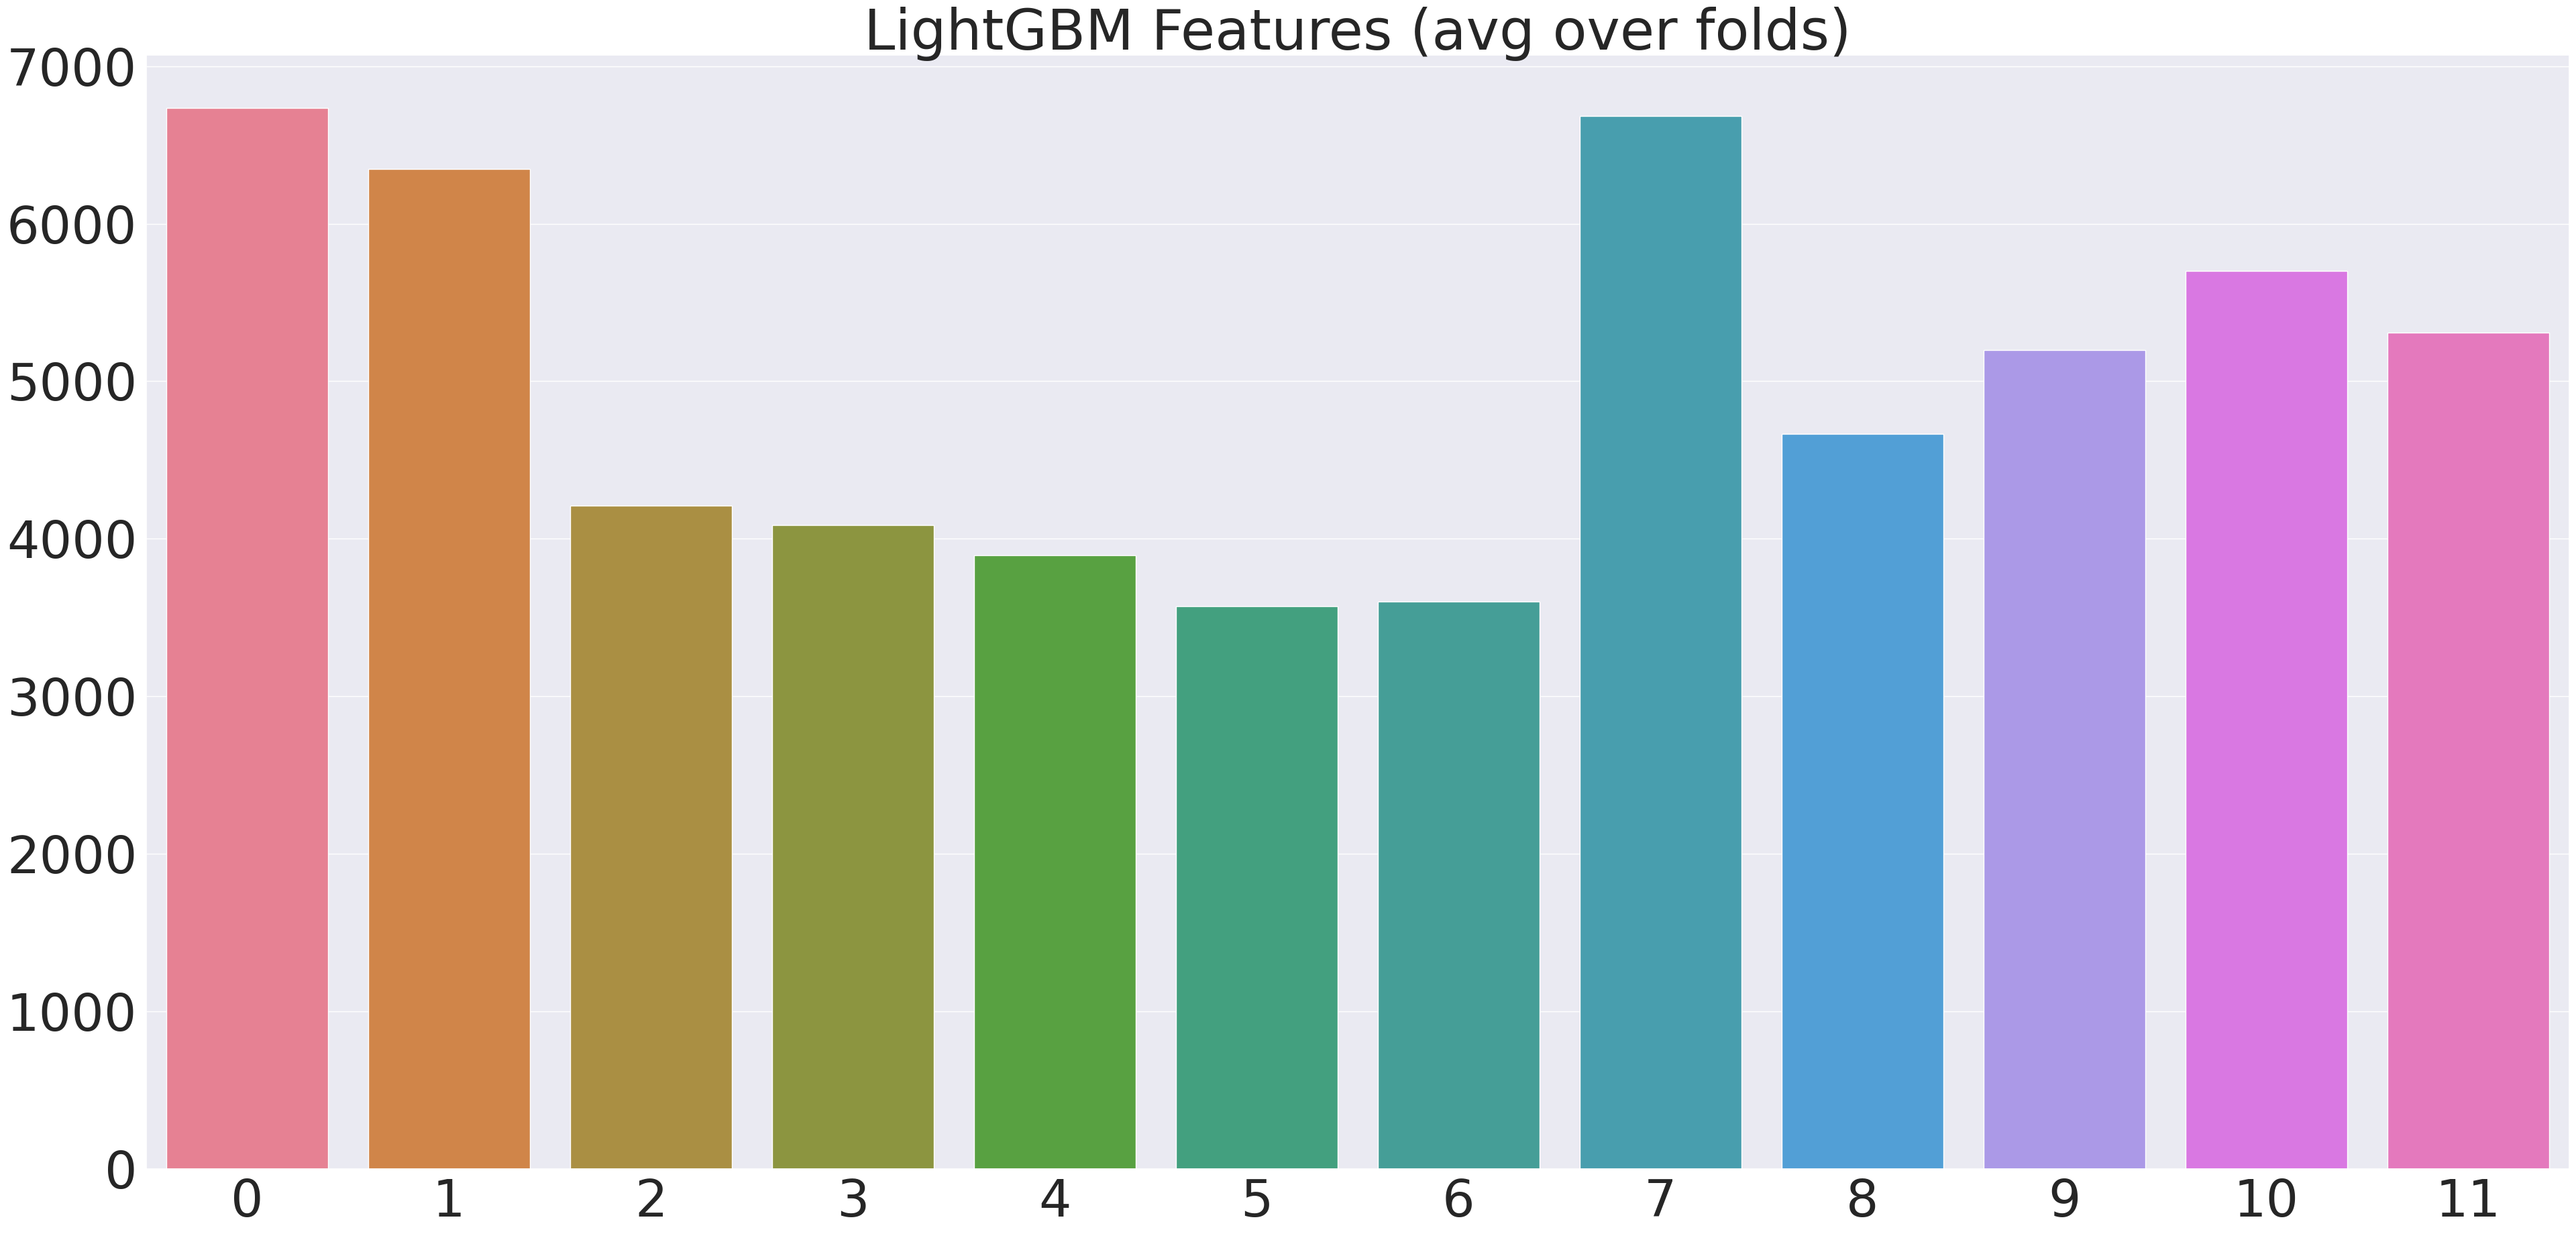

In [74]:
df_feature_importance = pd.DataFrame({'Value':models[1].feature_importances_})
df_feature_importance = df_feature_importance.T
plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)
sns.barplot(df_feature_importance)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances-02.png')
plt.show()

In [75]:
test_path =  '/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/evaluation/'
test_mask_path = '/home/sebastien/Documents/projects/solafune-solar-panel-detection/data/sample/'
#test_path =  '/tmp/kaggledata/solafue_solars/train/s2_image/'
#test_mask_path = '/tmp/kaggledata/solafue_solars/train/mask/'

masks = glob.glob(f'{test_mask_path}/*')
tests = glob.glob(f'{test_path}/*')
masks.sort()
tests.sort()

In [76]:
import os
if not os.path.isdir('output'):
    os.mkdir('output')

In [77]:
threshold = 0.1

for i, (m, t) in tqdm.tqdm(enumerate(zip(masks, tests))):
    basename = os.path.basename(m)
    output_file = f'output/{basename}'
    
    img = tifffile.imread(t).astype(np.float64)
    mask = tifffile.imread(m).astype(np.float64)

    # img = np.delete(img,[6,7,8],2)
    
    X = img.reshape(-1, 12)
    # X = img.reshape(-1, 9) 
    shape_mask = mask.shape
   
    pred = 0
    for model in models:
        pred = model.predict_proba(X) / len(models)
    
    pred_mask = (pred[:,1] > threshold).astype(np.uint8)
    # pred_mask = np.argmax(pred, axis=1).astype(np.uint8)
    
    pred_mask = pred_mask.reshape(shape_mask[0], shape_mask[1])
    
    tifffile.imwrite(output_file, pred_mask)
 

2066it [00:45, 45.53it/s]


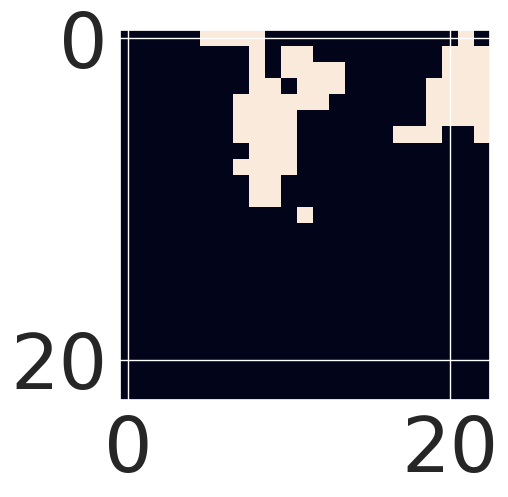

In [78]:
import matplotlib.pyplot as plt
plt.imshow(pred_mask)

In [79]:
import zipfile

output_folder_path = 'output'
with zipfile.ZipFile('output.zip', 'w') as zipf:
    for root, dirs, files in os.walk(output_folder_path):
        for file in files:
            zipf.write(os.path.join(root, file), file)